In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp

In [3]:
# download raw data

planck30 = hp.read_map('../data_files/LFI_SkyMap_030_1024_R2.01_full.fits')
planck44 = hp.read_map('../data_files/LFI_SkyMap_044_1024_R2.01_full.fits')
planck70 = hp.read_map('../data_files/LFI_SkyMap_070_1024_R2.01_full.fits')
planck100 = hp.read_map('../data_files/HFI_SkyMap_100_2048_R2.02_full.fits')
planck143 = hp.read_map('../data_files/HFI_SkyMap_143_2048_R2.02_full.fits')
planck217 = hp.read_map('../data_files/HFI_SkyMap_217_2048_R2.02_full.fits')
planck353 = hp.read_map('../data_files/HFI_SkyMap_353_2048_R2.02_full.fits')

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/Users/andrewlewis/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [4]:
# lower the resolution of the maps

planck30 = hp.ud_grade(planck30, 512)
planck44 = hp.ud_grade(planck44, 512)
planck70 = hp.ud_grade(planck70, 512)
planck100 = hp.ud_grade(planck100, 512)
planck143 = hp.ud_grade(planck143, 512)
planck217 = hp.ud_grade(planck217, 512)
planck353 = hp.ud_grade(planck353, 512)

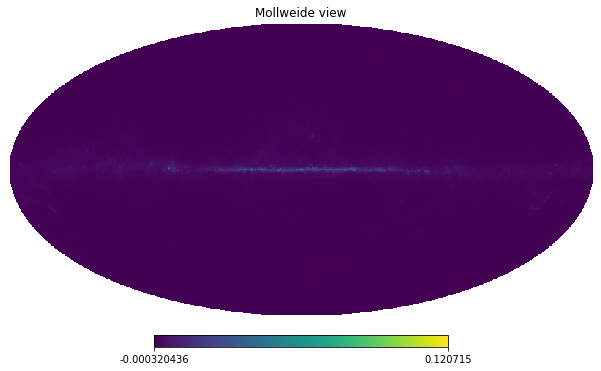

In [5]:
# example plot of raw data

hp.mollview(planck217,nest=False)

In [6]:
# implement the Lagrange method

map_array = np.array([planck30, planck44, planck70, planck100, planck143, planck217, planck353])

# define weighted map sum function

def map_sum(w):
    """Given an array of weights w,returns a weighted sum of the maps"""
    return w@map_array

In [7]:
def get_H():
    i = 0
    j = 0
    H = np.zeros((len(map_array), len(map_array)))
    for m in map_array:
        
        j = 0
        for n in map_array:
            product = m*n
            product_sum = np.sum(product)
            H[i, j] = product_sum
            j+=1
        i+=1
    return H

In [8]:
H = get_H()


In [9]:
e = np.ones(len(map_array))

In [10]:
w = (np.linalg.inv(H)@e) / (e.T@H@e)

In [11]:
print(w)
print(np.sum(w))
print(w/np.sum(w))
opt_map = map_sum(w/np.sum(w))
print(opt_map)

[-0.00288621  0.0104061  -0.0195659   0.01101462  0.02525271 -0.00272827
 -0.00060967]
0.02088339220663807
[-0.13820596  0.4982956  -0.93691211  0.52743458  1.20922469 -0.13064282
 -0.02919399]
[-1.65588589e-04 -7.40888188e-05 -1.31758658e-05 ...  9.81450736e-05
  1.01674421e-04  9.97091627e-05]


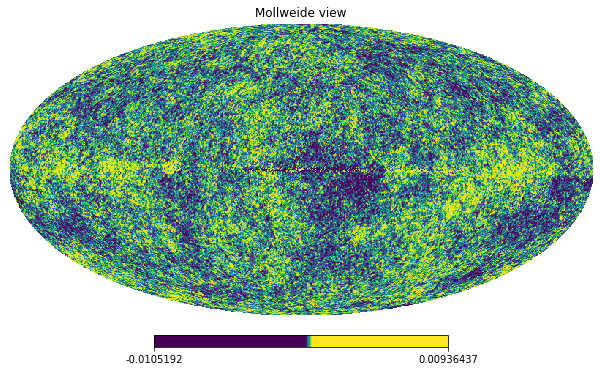

In [12]:
hp.mollview(opt_map, nest=False, norm='hist')

In [ ]:
def sliceFixer(num_slices,array_maps):
    #Creates n different slices of the cmb, and weights them correspondingly
    length_maps = len(array_maps[0])
    slicedUpMaps = []
    #Start for the slices
    lowerBound = 0
    upperBound = int(length_maps/num_slices)
    
    for i in range(num_slices):   #Goes over the number of slices
        mapSlicesToAdd = []
        for j in array_maps:
            mapSlicesToAdd.append(j[lowerBound:upperBound])
        slicedUpMaps.append(mapSlicesToAdd)  #Add the map slices
        lowerBound = upperBound
        upperBound += int(length_maps/num_slices)
    return slicedUpMaps
        

        
        

    
    
    
    

In [25]:
sliceFixer(5,map_array)


NameError: name 'numslices' is not defined

In [ ]:
#Me messing around

print(hp.nside2npix(512))
shape = np.arange(hp.nside2npix(16))
shape = np.linspace(0,1,32)
shape = np.ones(3145728)
print(shape)
shape[int(3145728/12):int(3145728/12)*2] = 3
hp.mollview(shape, title="Mollview image RING")